# 2024-ComputerVision Final Project

## Setup

In [1]:
import os
import json
import random

import cv2
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms.v2 as T

import matplotlib.pyplot as plt

from transforms import FixedAspectResize, RandomSpots, Binarization

## Aida

### Preview

In [2]:
with open("data/cleaned_aida/train_test_split.json") as f:
    data_split_conf = json.load(f)

sample_ids = data_split_conf['train_ids']

806a0403-ca01-49d6-8711-8ce86b6f90cf


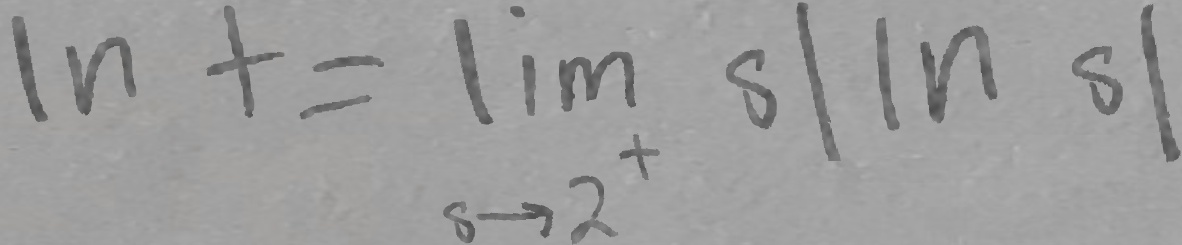

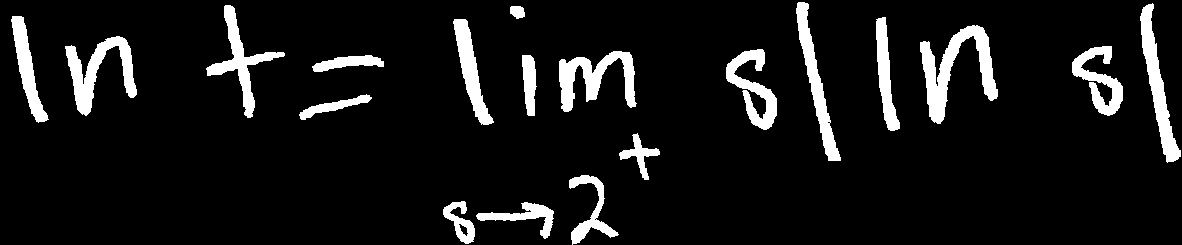

In [3]:
demo_id = random.choice(sample_ids)
demo_aida = Image.open(f"data/cleaned_aida/{demo_id}/raw_image.jpg")  # (H, W, C)
demo_aida_bin = Image.open(f"data/cleaned_aida/{demo_id}/masked_image.png")

print(demo_id)
display(demo_aida)
display(demo_aida_bin)

In [15]:
transform = T.Compose([
    RandomSpots(spots_range=(3, 7), w_range=(5, 10), h_range=(3, 5)),
    T.ToImage(),
    FixedAspectResize(512),
    T.RandomRotation(degrees=10),
])

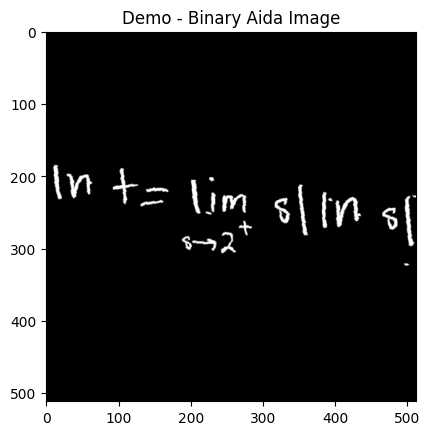

In [19]:
new_demo_aida_bin = transform(demo_aida_bin).squeeze(0)

plt.imshow(new_demo_aida_bin, cmap='gray')
plt.title("Demo - Binary Aida Image")
plt.show()

## Blackboards

### Preview

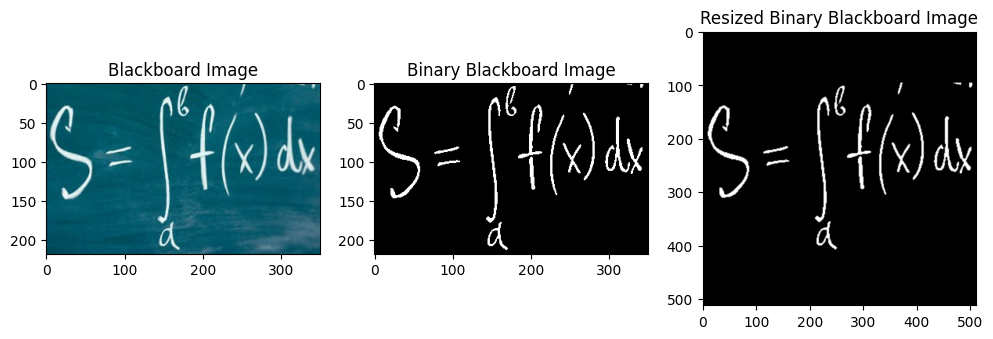

In [11]:
demo_bb_name = "crop_6"
demo_bb = cv2.imread(f"data/demo/blackboards/{demo_bb_name}.jpg")  # (H, W, C)

binarizer = Binarization()
demo_bb_bin = binarizer(demo_bb)

demo_bb_bin = Image.fromarray(demo_bb_bin)
resizer = FixedAspectResize(512)
demo_bb_resized = resizer(demo_bb_bin)
demo_bb_resized = np.array(demo_bb_resized)


fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(cv2.cvtColor(demo_bb, cv2.COLOR_BGR2RGB))
axes[0].set_title("Blackboard Image")
axes[1].imshow(demo_bb_bin, cmap='gray')
axes[1].set_title("Binary Blackboard Image")
axes[2].imshow(demo_bb_resized, cmap='gray')
axes[2].set_title("Resized Binary Blackboard Image")
plt.show()